In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
np.random.seed(42)
n = 2000

In [3]:
X = np.random.normal(0, 1, n)

In [4]:
T = np.random.binomial(1, p=1 / (1 + np.exp(-X)))

In [5]:
true_tau = 2.0

In [6]:
Y = true_tau * T + 0.5 * X + np.random.normal(0, 1, n)

In [7]:
df = pd.DataFrame({"X": X, "T": T, "Y": Y})
print(df.head())

          X  T         Y
0  0.496714  1  3.316736
1 -0.138264  0  0.534989
2  0.647689  1  4.627483
3  1.523030  1  1.282071
4 -0.234153  1  3.142157


In [8]:
prop_model = LogisticRegression()
prop_model.fit(df[["X"]], df["T"])
df["e_X"] = prop_model.predict_proba(df[["X"]])[:, 1]

In [9]:
outcome_model = LinearRegression()
outcome_model.fit(df[["T", "X"]], df["Y"])

# Predict outcomes under treatment and control
df["Y1_hat"] = outcome_model.predict(pd.DataFrame({"T": 1, "X": df["X"]}))
df["Y0_hat"] = outcome_model.predict(pd.DataFrame({"T": 0, "X": df["X"]}))

ATE_regression = np.mean(df["Y1_hat"] - df["Y0_hat"])
print(f"Outcome Regression ATE: {ATE_regression:.3f}")

Outcome Regression ATE: 2.013


In [10]:
df["w"] = np.where(df["T"] == 1, 1 / df["e_X"], 1 / (1 - df["e_X"]))

ATE_IPTW = np.mean(df["w"] * (df["T"] * df["Y"] / df["e_X"] - (1 - df["T"]) * df["Y"] / (1 - df["e_X"])))
print(f"IPTW ATE: {ATE_IPTW:.3f}")

IPTW ATE: 4.313


In [11]:
dr_term = (df["T"] - df["e_X"]) * (df["Y"] - df["T"] * df["Y1_hat"] - (1 - df["T"]) * df["Y0_hat"]) / (df["e_X"] * (1 - df["e_X"]))
ATE_DR = np.mean(df["Y1_hat"] - df["Y0_hat"] + dr_term)
print(f"Doubly Robust ATE: {ATE_DR:.3f}")

Doubly Robust ATE: 2.026


In [12]:
def standardized_mean_diff(x, t, w=None):
    """Compute standardized mean difference."""
    if w is None:
        m1, m0 = x[t == 1].mean(), x[t == 0].mean()
        s = np.sqrt((x[t == 1].var() + x[t == 0].var()) / 2)
    else:
        m1 = np.average(x[t == 1], weights=w[t == 1])
        m0 = np.average(x[t == 0], weights=w[t == 0])
        s = np.sqrt((np.average((x - np.average(x, weights=w))**2, weights=w)))
    return (m1 - m0) / s

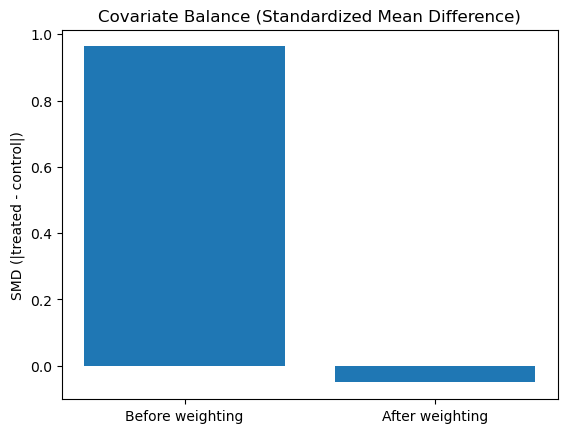

In [13]:
smd_before = standardized_mean_diff(df["X"], df["T"])
smd_after = standardized_mean_diff(df["X"], df["T"], df["w"])

plt.bar(["Before weighting", "After weighting"], [smd_before, smd_after])
plt.title("Covariate Balance (Standardized Mean Difference)")
plt.ylabel("SMD (|treated - control|)")
plt.show()

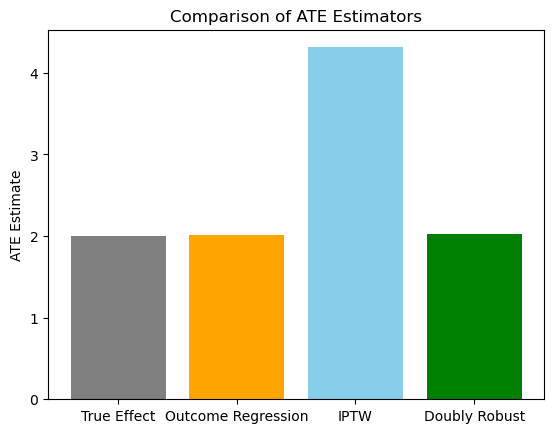

In [14]:
methods = ["True Effect", "Outcome Regression", "IPTW", "Doubly Robust"]
values = [true_tau, ATE_regression, ATE_IPTW, ATE_DR]

plt.bar(methods, values, color=["gray", "orange", "skyblue", "green"])
plt.ylabel("ATE Estimate")
plt.title("Comparison of ATE Estimators")
plt.show()